In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import os
import analysis_marisol as am
from analysis_marisol import fit_data_to_polynomial, find_V_floating, Vplasma_from_model, get_j_i_star, find_Te_fit, find_Te_n_e_iteration
from constants import e, k, m_i, mu, A_probe, r_p, l_p, k_eV, K_to_eV, m_e
from scipy.signal import savgol_filter


In [4]:
# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

(2, 4)


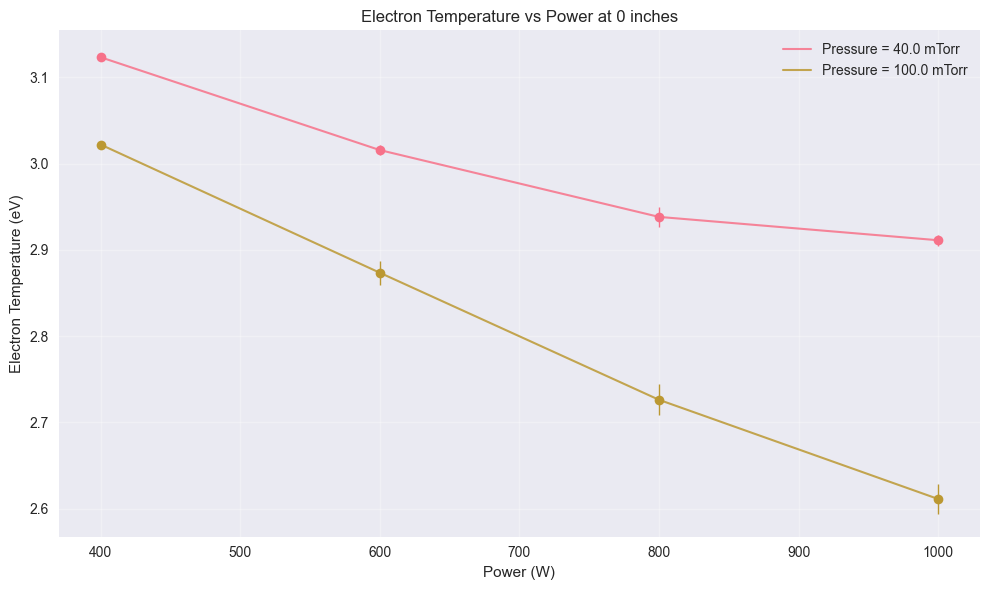

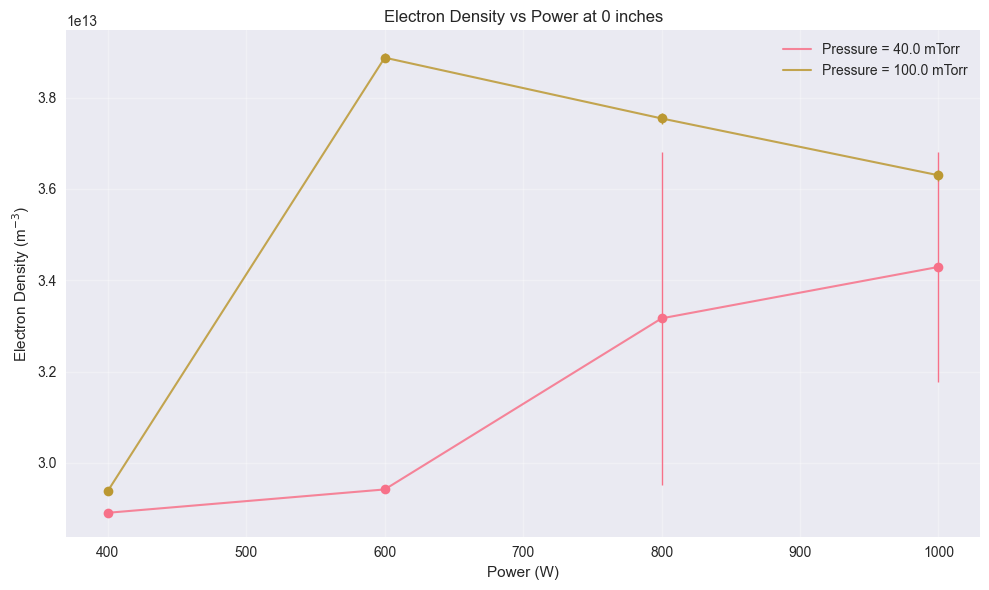

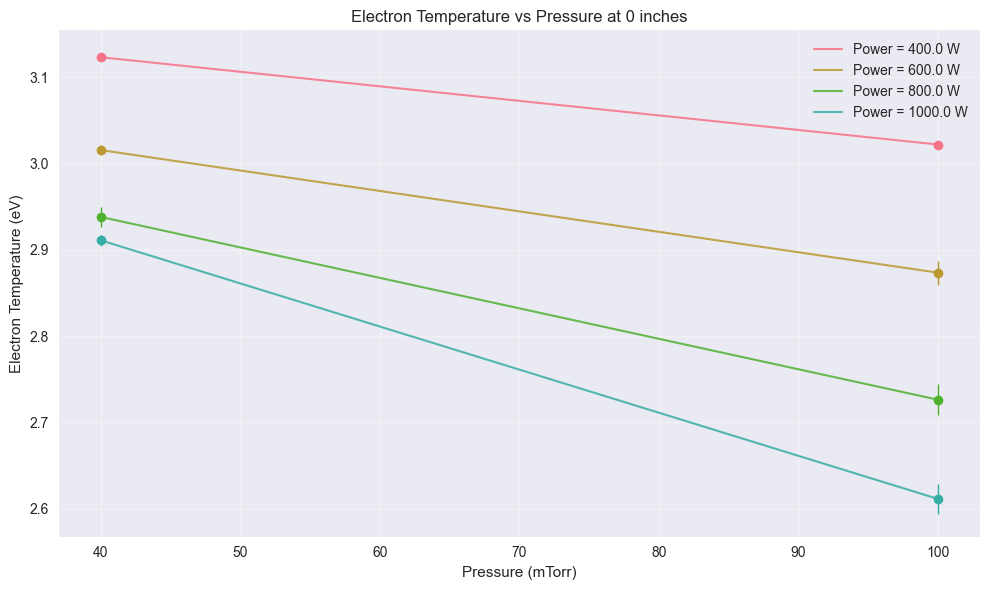

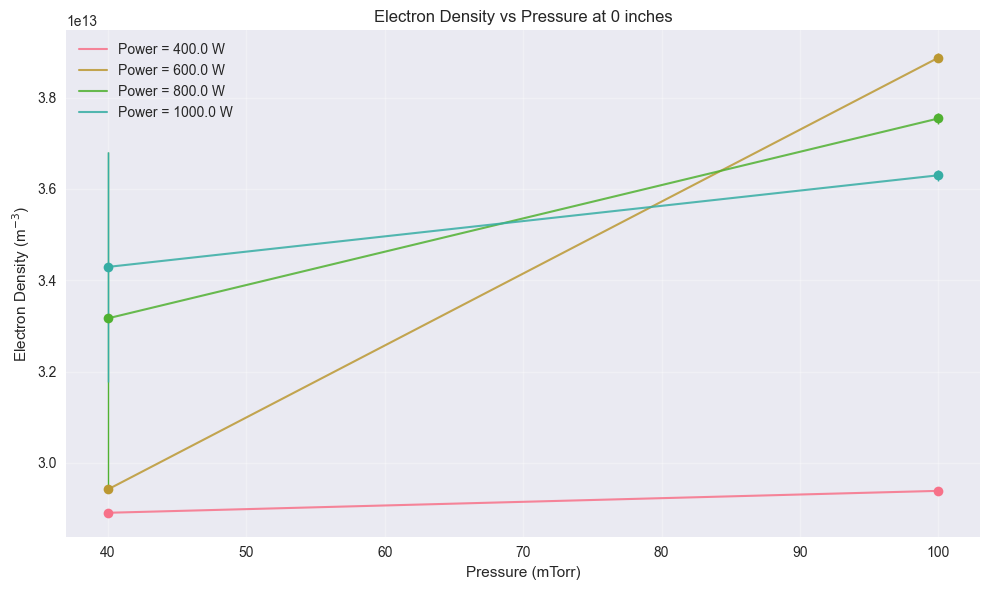

(2, 4)


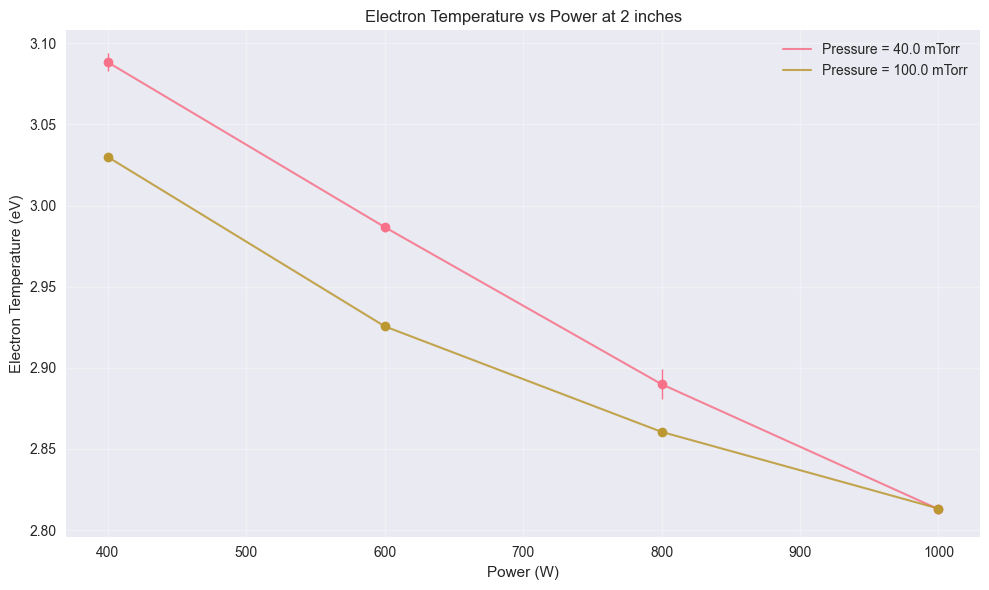

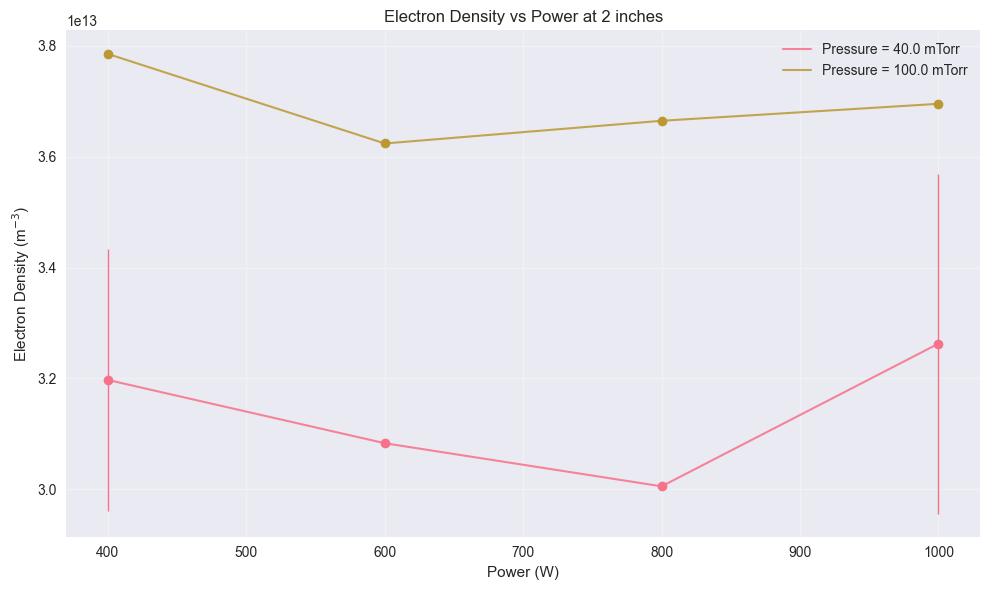

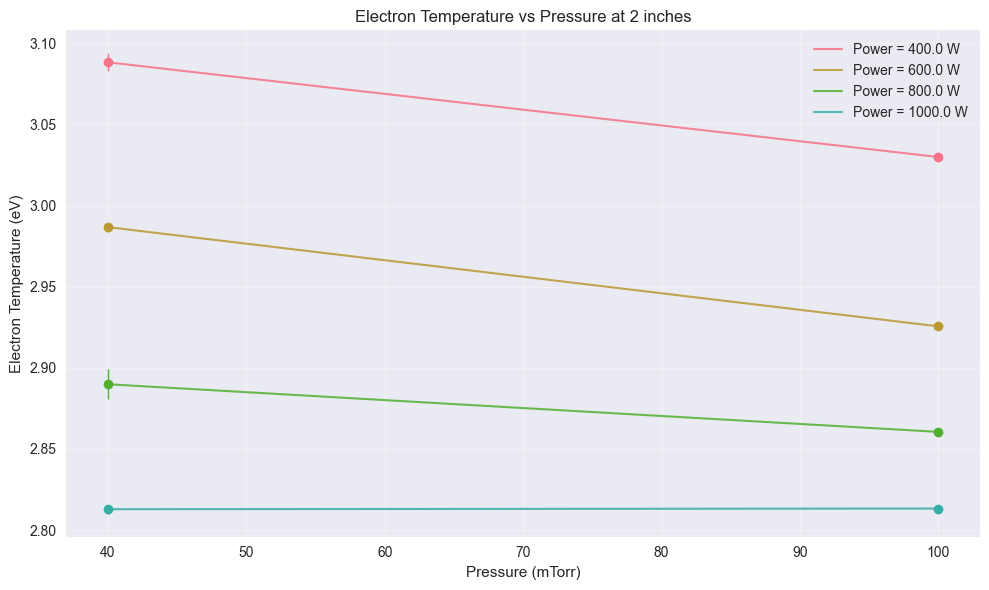

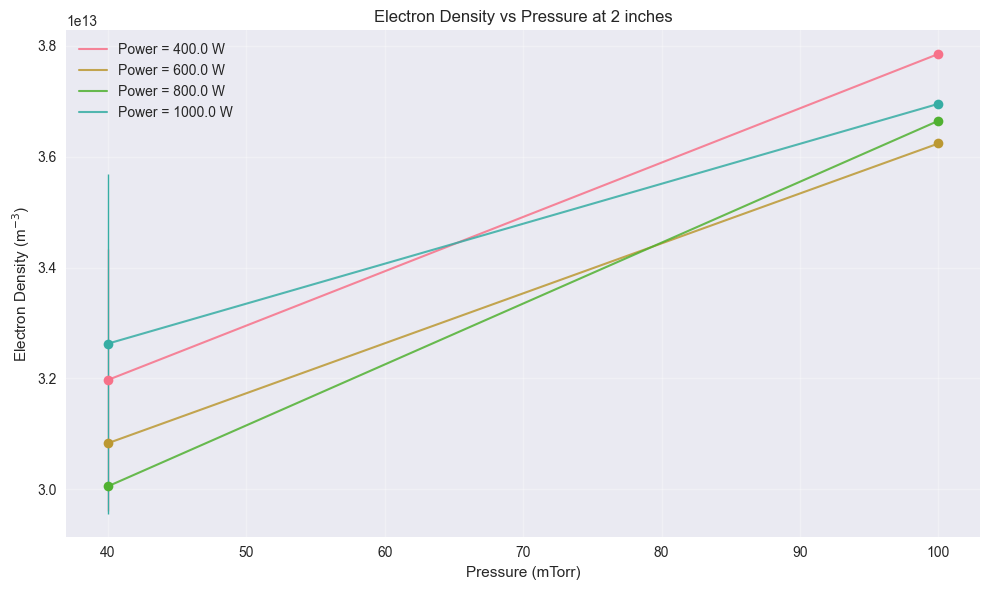

(2, 4)


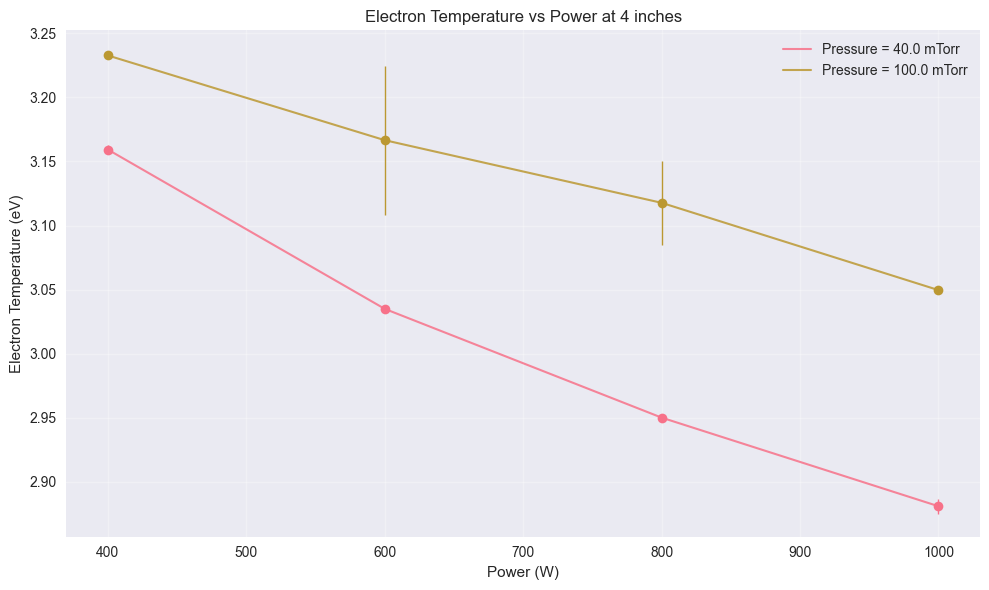

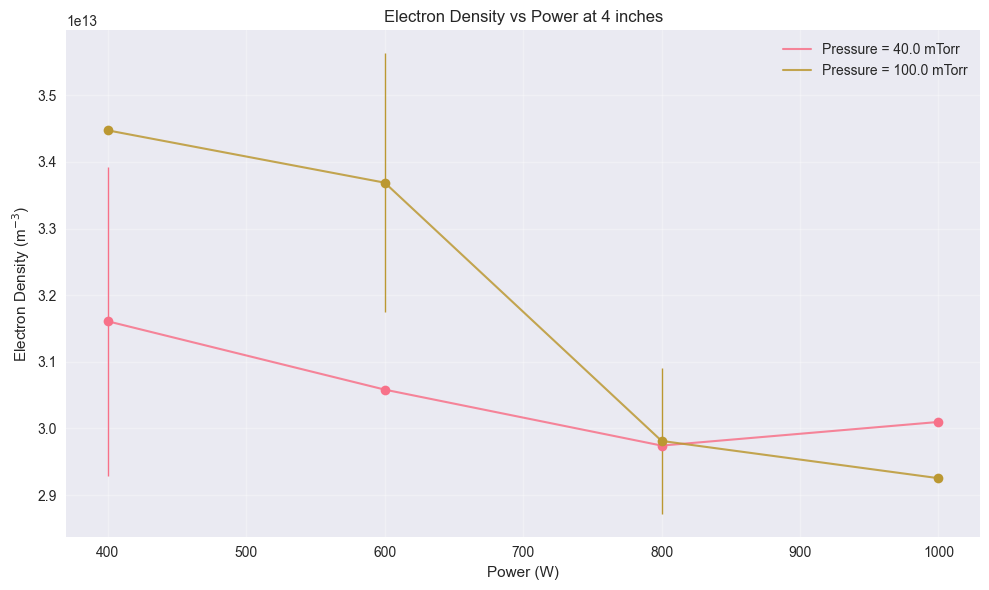

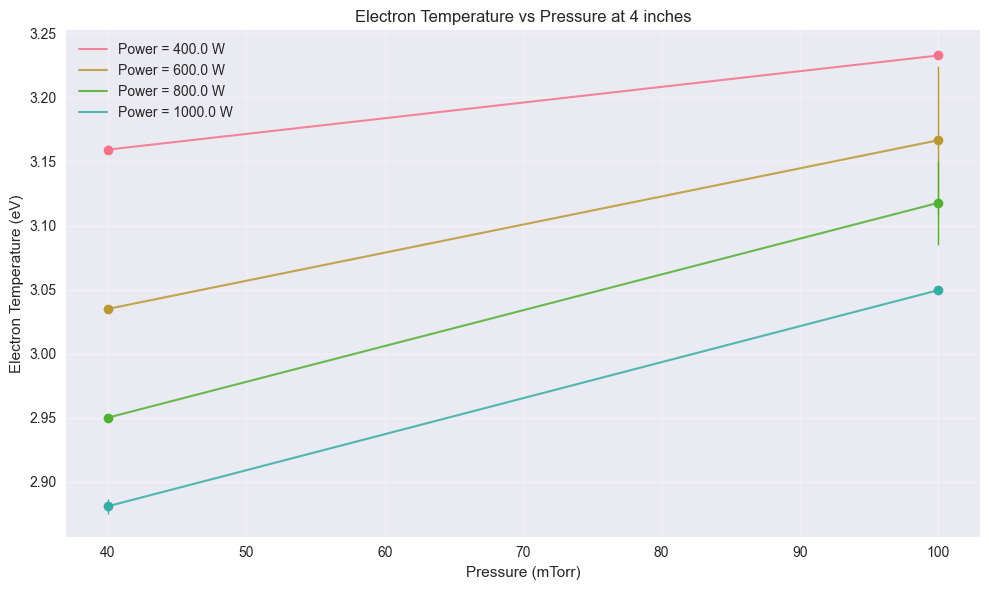

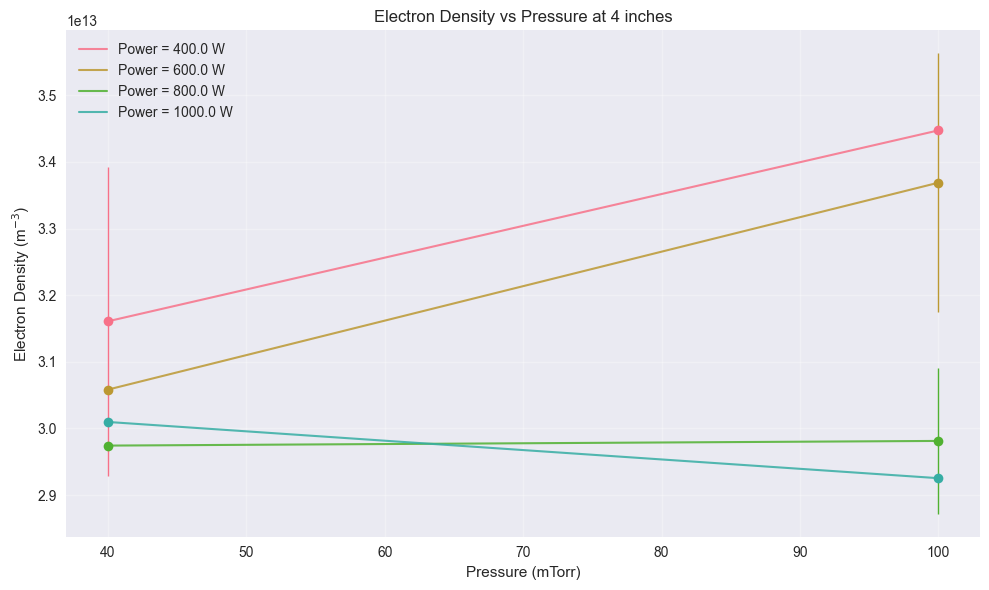

(2, 4)


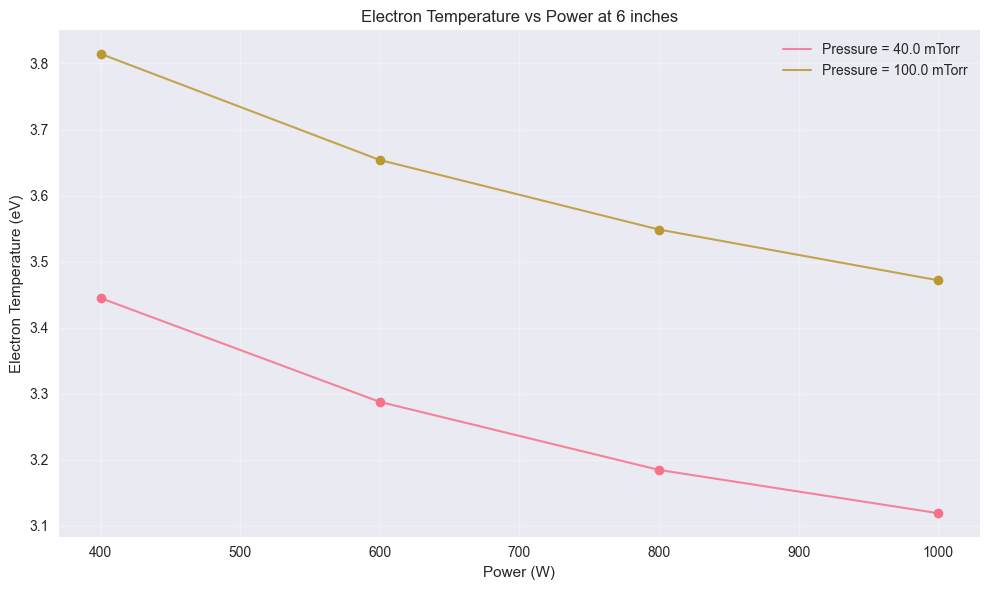

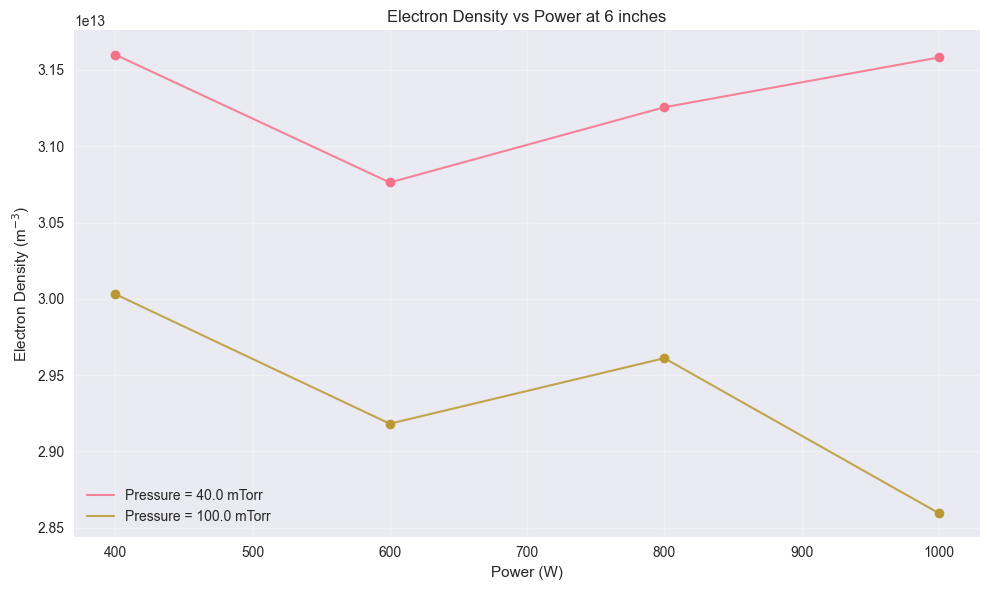

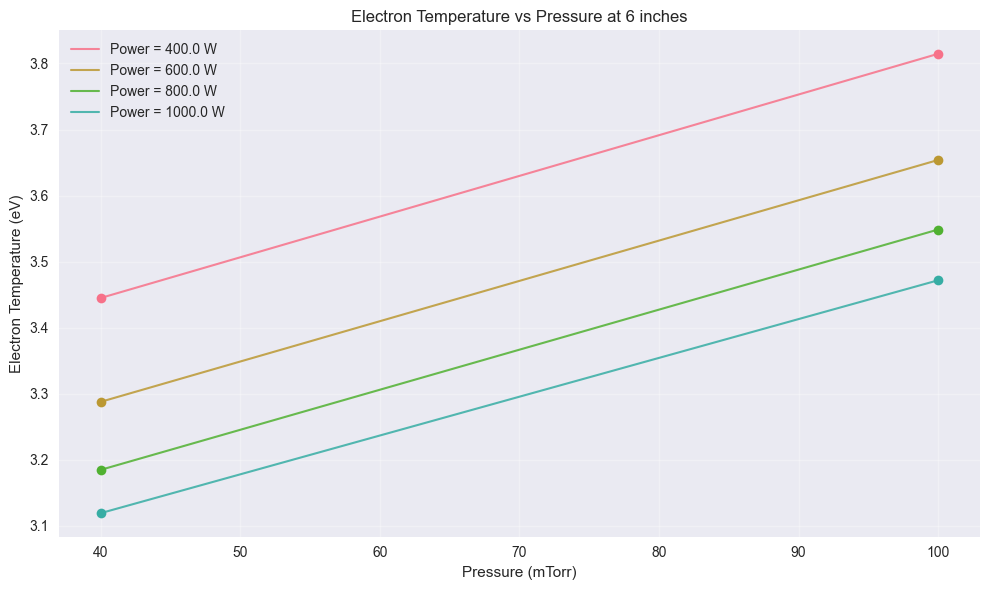

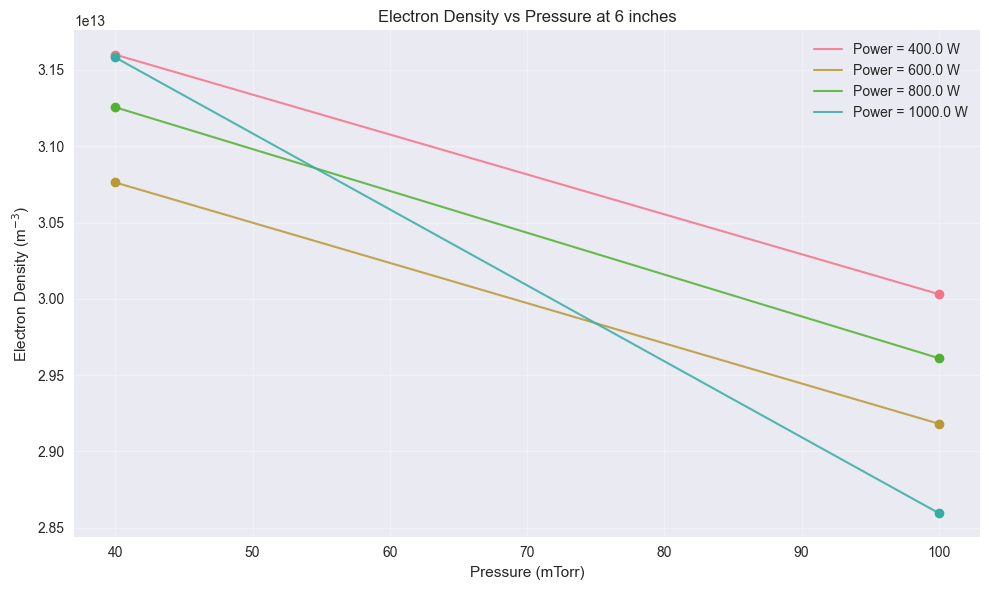

In [5]:
positions = [0,2,4,6]
pressures = [40,100]
powers = [400, 600, 800, 1000]

Te_matrix_list, ne_matrix_list, Te_std_matrix_list, ne_std_matrix_list, positions = am.get_Te_ne_matrix_vs_position()

for i, x in enumerate(positions):
    Te_matrix = np.array(Te_matrix_list[i])
    print(Te_matrix.shape)
    Te_std_matrix = Te_std_matrix_list[i]
    ne_matrix = ne_matrix_list[i]
    ne_std_matrix = ne_std_matrix_list[i]

    am.plot_Te_ne_vs_pressure("Te", "Pressure", pressures, powers, Te_matrix, Te_std_matrix, x)
    am.plot_Te_ne_vs_pressure("ne", "Pressure", pressures, powers, ne_matrix, ne_std_matrix, x)

    am.plot_Te_ne_vs_pressure("Te", "Power", pressures, powers, Te_matrix, Te_std_matrix, x)
    am.plot_Te_ne_vs_pressure("ne", "Power", pressures, powers, ne_matrix, ne_std_matrix, x)


101
736


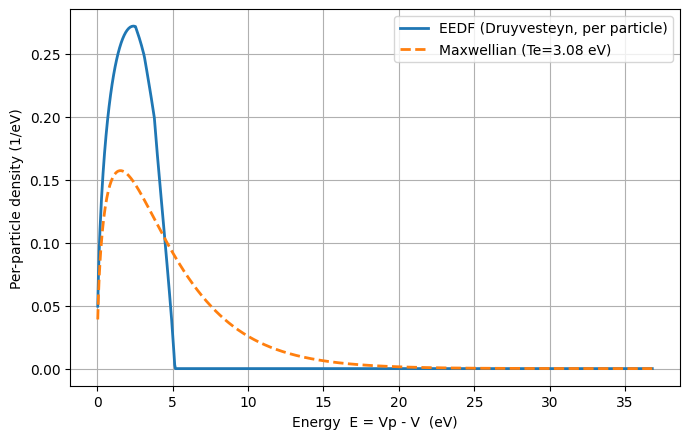

In [57]:
file = "/Users/marisolvelapatino/Desktop/Langmuir-Probe/LP/2in/40 mTorr/400W/Trace_41p3mTorr_400W_2in_1.csv"  # your CSV

Te_K, ne, I_e = find_Te_n_e_iteration(file)             # Te in K, ne in m^-3, I_e array
I, V, coeffs, model = fit_data_to_polynomial(file)
Vp, Iplasma, min_d2I, info = Vplasma_from_model(model, V)


fig, ax = am.plot_eedf_vs_maxwellian(
    I_e, V, Vp, Te_K=Te_K, ne_m3=ne, A_probe_m2=A_probe,
    smooth_span_V=5.0, polyorder=3, calibrate_to_ne=True
)

plt.show()

101
919
calibrating to ne
101
733
calibrating to ne
101
923
calibrating to ne
(3, 923)


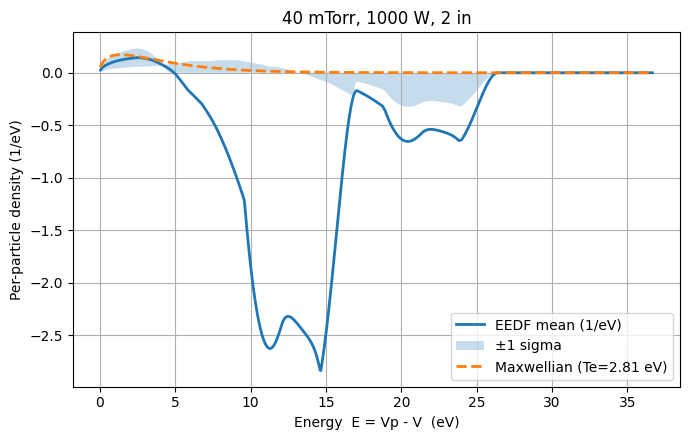

In [32]:
def eedf_per_eV_from_Ie(V, I_e, n_e, Vp, smooth_span_V=10.0, poly=3):
    V = np.asarray(V, float)
    Ie = np.asarray(I_e, float)

    # --- use only retarding region
    m = V <= Vp
    Vr = V[m]
    Ier = Ie[m]

    # --- make electron current negative by convention
    Ie_conv = -Ier

    # --- stable 2nd derivative
    dV = float(np.median(np.diff(Vr)))
    win = max(7, int(round(smooth_span_V/dV)) | 1)   # ~10 V span, force odd
    d2I = savgol_filter(Ie_conv, window_length=win, polyorder=poly,
                        deriv=2, delta=dV, mode='interp')

    # --- per-eV EEDF
    
    # Energy in J (E_J = e * (Vp - V) )
    E_eV = -(Vp - Vr)            # eV numerically
    E_J  = 1 * E_eV             # Joules

    # Druyvesteyn in SI -> f_J [m^-3 J^-1]
    pref_SI = -4.0 / (A_probe * e**2) * np.sqrt(m_e / (2.0 * e))
    f_J = pref_SI * np.sqrt(np.clip(E_J, 0, None)) * d2I

    # Convert to per-eV and then to per-particle if you want 1/eV
    f_eV = f_J / e              # m^-3 eV^-1
    p_eV = f_eV / n_e           # 1 / eV


    return E_eV, p_eV, d2I, Vr

def maxwellian_eedf(E_eV, Te_eV):
    E = np.clip(np.asarray(E_eV, float), 0, None)
    Te = float(Te_eV)
    return (2/np.sqrt(np.pi)) * (np.sqrt(E) / (Te**1.5)) * np.exp(-E/Te)


file = '/Users/marisolvelapatino/Desktop/Langmuir-Probe/LP/2in/40 mTorr/400W/Trace_41p3mTorr_400W_2in_1.csv'

#only using I_e
Te, ne, I_e = find_Te_n_e_iteration(file)

print(ne/10**13)
I_e = np.array(I_e)
## Only using V and V_plasma
I, V, coeffs, model = fit_data_to_polynomial(file)


V_plasma, Iplasma, min_d2I, info = Vplasma_from_model(model, V)
data_ = {'I_e (A)': I_e, 'V-V_plasma (V)': V-V_plasma}
data = pd.DataFrame(data_)
data.to_csv('data.csv', index=False)
print(Te, ne)



E, f, d2I, Vret = eedf_per_eV_from_Ie(V, I_e, ne, Vp=V_plasma)

# Final plot:
plt.figure(figsize=(6,4))

#plt.plot(E, f, label="EEDF (data)")
fE = maxwellian_eedf(E, Te*K_to_eV, ne)
plt.plot(E, fE, label='Maxwellian energy PDF vs V (E = eV)')
plt.plot(E, np.clip(f,0,None), label='EEDF (data)')

#plt.plot(E[f>0], f[f>0])
plt.xlabel('V_plasma - V (V)')
plt.ylabel('EEDF (1/eV)')
plt.tight_layout()
plt.legend()
plt.show()




3.531433373104678
35751.558918638635 35314333731046.78


TypeError: maxwellian_eedf() takes 2 positional arguments but 3 were given

<Figure size 600x400 with 0 Axes>

Found V_plasma:  28.742846419560887  V , with V floating :  6.060457425775343


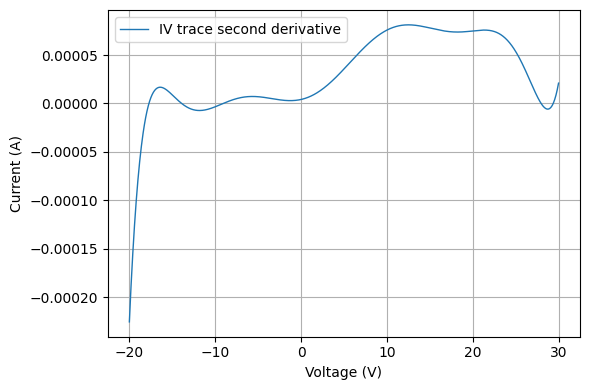

T_e found to be:  33852.58500157592
T_e in eV found to be:  2.917190067436711
n_e found to be:  29.91061310321781 e12 m^-3


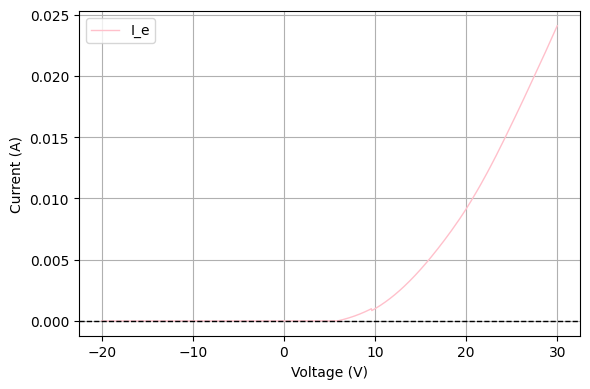

In [34]:
path = '/Users/marisolvelapatino/Desktop/Langmuir-Probe/LP/10 mTorr/400W/Trace_10p8mTorr_400W_1.csv'
## Model data with a polynomial fit.
I, V, coeffs, model = fit_data_to_polynomial(path)

## Find the floating potential
V_floating = find_V_floating(coeffs, domain=(min(V), max(V)))

## Find the plasma potential
V_plasma, Iplasma, min_d2I, info = Vplasma_from_model(model, V)

print("Found V_plasma: ", V_plasma, " V , with V floating : ", V_floating)

am.plot_dIdV2(model, V)
#V_plasma, V_floating, T_e, n_e, j_i_star, I_ion = routine(path)
T_e, n_e, I_e = find_Te_n_e_iteration(path)
print("T_e found to be: ", T_e)
print("T_e in eV found to be: ", T_e*K_to_eV)
print("n_e found to be: ", n_e/1e12, "e12 m^-3")
plt.figure(figsize=(6,4))

#plt.plot(V, I, '-', lw=1 , label='Data')

I_hat = model(V)
#plt.plot(V, I_hat, '--', lw=1, label='Fit')


#plt.axhline(y=I[20], color='red', linestyle='--', lw=1)

plt.plot(V, I_e, '-', color='pink', lw=1, label='I_e')

#plt.axvline(x=V_floating, color='magenta', linestyle='--', lw=1, label='V_floating')
#plt.axvline(x=V[200], color='yellow', linestyle='--', lw=1, label='V-200')
#plt.axvline(x=V_plasma, color='green', linestyle='--', lw=1, label='V_plasma')
#plt.axvline(x=0, color='black', linestyle='--', lw=1)
plt.axhline(y=0, color='black', linestyle='--', lw=1)

plt.xlabel("Voltage (V)")
plt.ylabel("Current (A)")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.ylim(-1e-5, 1e-6)  for I_e any negative value is set to 1e-7
#plt.xlim(-21, -17.5)
plt.show()

